In [33]:
import os, glob, numpy as np, csv, math
import matplotlib.pyplot as plt
from scipy import signal, fftpack
from matplotlib.legend_handler import HandlerLine2D


dir_path = os.path.dirname(os.path.realpath('plotter_notebook.ipynb'))
wrkdir = os.path.join(dir_path,'data')
csv_files = os.path.join(wrkdir,'*.csv')
meta_files = os.path.join(wrkdir,'*.txt')
trackdata = glob.glob(csv_files)
metadata = glob.glob(meta_files)
n_files = np.size(trackdata)

location = 'average'
volumes = [0.5,1.0,2.0,5.0,10.0]
angles= [2.0,3.5,5.0]

# Standard plot format

In [34]:
def basic_plot_format(subplot_label,x_label,y_label,major_grid,minor_grid,legend):
    # General plot formatting for relatively good plots. adjustments may be necessary
    # sub_plot_label, usually defined by 'ax' and a number
    # x_label and y_label must be type 'str'... Can use LaTeX for typsetting
    # major_grid, minor_grid, and legend are boolean
    
    plt.style.use('classic')
    font = {'family' : 'Times New Roman',
            'weight' : 0,
            'size'   : 16}
    plt.rc('font',**font)
    
    subplot_label.spines['right'].set_color('none')
    subplot_label.spines['top'].set_color('none')
    subplot_label.yaxis.set_ticks_position('left')
    subplot_label.xaxis.set_ticks_position('bottom')
    subplot_label.minorticks_on()
    subplot_label.set_xlabel(x_label,fontsize=18)
    subplot_label.set_ylabel(y_label,fontsize=18)

    subplot_label.grid(b=major_grid,which='major')
    subplot_label.grid(b=minor_grid,which='minor')
    
    if legend == False:
         0   
    else:
        legend =  subplot_label.legend(numpoints = 1,bbox_to_anchor=(1, 1),loc='upper left',frameon=False,fontsize=10)
        legend.get_frame().set_facecolor('white')
        return legend


# Retrieve drop variables

In [35]:
def get_variables(metadata):
    f = open(metadata[0],"r")
    drop_vars = list(csv.reader(f))
    f.close()
    
    
    drop_meta = {}
    for i in range(n_files):
        drop_meta[drop_vars[i+1][0]] = {}
        n_meta = np.size(drop_vars[0][1:])
        for n in range(n_meta):
            drop_meta[drop_vars[i+1][0]][drop_vars[0][n+1].split('_')[0]] = float(drop_vars[i+1][n+1])

    meta = drop_meta
    return meta

meta = get_variables(metadata)

meta is a nested dictionary with global key by drop number and sub keys 'Angle', 'Volume', 'ILfront', 'ILback', and 'Scale'

# Retrieve data

In [36]:
def get_data(wrkdir,csv_files,trackdata,n_files):
    
    total_drop_data = {}
    
    
    for i in range(n_files):
        (location, name) = os.path.split( trackdata[i] )
        
        f = open(trackdata[i],"r")
        drop_data = list(csv.reader(f))
        f.close()
        
        col_names = drop_data[0]
        n_col = np.size(drop_data[0])
        drop_data = np.asarray(drop_data[1:],dtype=float)
        total_drop_data[name[:-4]] = {}
        for j in range(n_col):
            total_drop_data[name[:-4]][col_names[j]] = drop_data[:,j]

    return total_drop_data

data = get_data(wrkdir,csv_files,trackdata,n_files)

# Savitsky Golay Filtering 

## Displacement and velocity plots

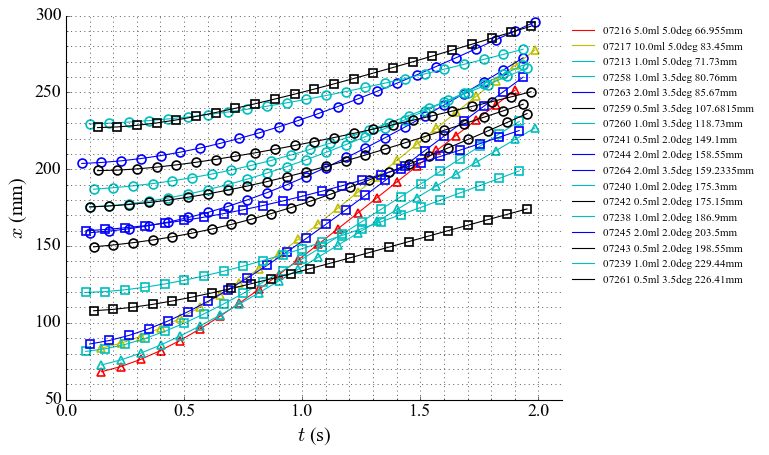

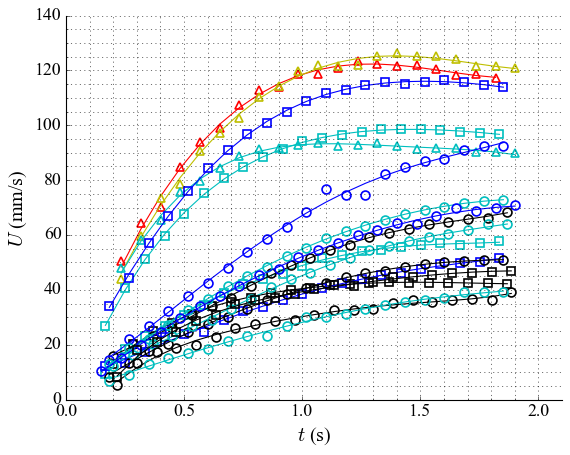

In [37]:
def filtering_data(data,meta,volumes,angles,location):
    fig1 = plt.figure(facecolor="white")
    fig2 = plt.figure(facecolor="white")
    
    v_norm = {}
    x_max = {}
    
    for key in sorted(meta, key = lambda x: meta[x]['ILback']):
        if(meta[key]['Volume'] in volumes and meta[key]['Angle'] in angles):  # checks for called volumes and angles
            dat = data[key][location][1:] 
            t = data[key]['time'][1:]
        
            slice_num = 5
            dat_sliced = dat[::slice_num]
            t_sliced = t[::slice_num]
            n_sliced = np.size(dat_sliced)
            
            window1 = int(np.floor(n_sliced/2)*2-1)
            window2 = window1-4
            window3 = window2-4

            poly_fit = 5
            x1 = signal.savgol_filter(dat_sliced,window1,poly_fit)
            x2 = signal.savgol_filter(x1,window2,poly_fit)
            dat_filt = signal.savgol_filter(x2,window3,poly_fit)
            
            
            dxdt_savgol = np.zeros(np.size(dat_sliced)-2)
            for i in range(np.size(dat_sliced)-2):
                dxdt_savgol[i] = (dat_filt[i+2]-dat_filt[i])/(2*(t_sliced[i+1]-t_sliced[i]))
                
            
            dxdt_centraldiff = np.zeros(np.size(dat_sliced)-2)
            for i in range(np.size(dat_sliced)-2):
                dxdt_centraldiff[i] = (dat_sliced[i+2]-dat_sliced[i])/(2*(t_sliced[i+1]-t_sliced[i]))
            
            x_max[key] = max(dat_sliced)
            v_norm[key] = max(dxdt_centraldiff)
    


    
            ax = fig1.add_subplot(1,1,1)
            # some plot formatting stuff, setting marker colors/types for various volumes
            if(meta[key]['Volume'] == 0.5):
                color = 'k'
                style = None
            elif(meta[key]['Volume'] == 1.0):
                color = 'c'
                style = None
            elif(meta[key]['Volume'] == 2.0):
                color = 'b'
                style = None
            elif(meta[key]['Volume'] == 5.0):
                color = 'r'
                style = None
            elif(meta[key]['Volume'] == 10.0):
                color = 'y'
                style = None
            if(meta[key]['Angle'] == 2.0):
                style2 = 'o'
            elif(meta[key]['Angle'] == 3.5):
                style2 = 's'
            elif(meta[key]['Angle'] == 5.0):
                style2 = '^'
            dropno = key+' '
            vol = str(meta[key]['Volume'])+'ml '
            angl = str(meta[key]['Angle'])+'deg '
            IL = str( data[key][location][0])+'mm '
            legend_label = dropno+vol+angl+IL
            
            ax.plot(t_sliced,dat_sliced,'.',marker=style2, c = color,fillstyle='none',markeredgewidth=1.5,ms=8)
            ax.plot(t_sliced,dat_filt,c=color,marker=style,linewidth=1,label = legend_label)
            legend1 = basic_plot_format(subplot_label = ax, x_label = '$t$ (s)', y_label = '$x$ (mm)', major_grid = True, minor_grid = True, legend = True)
            ax.set_xlim([0,2.1])        
            ax2 = fig2.add_subplot(1,1,1)
            ax2.plot(t_sliced[1:-1],dxdt_centraldiff,marker=style2,linewidth=0, c = color,fillstyle='none',markeredgewidth=1.5,ms=8)
            ax2.plot(t_sliced[1:-1],dxdt_savgol,c=color,marker=style,linewidth=1,label = legend_label)
            
            legend2 = basic_plot_format(subplot_label = ax2, x_label = '$t$ (s)', y_label = '$U$ (mm/s)', major_grid = True, minor_grid = True, legend = False)
            ax2.set_xlim([0,2.1])
            
    fig1.savefig('Figures/positions.png',dpi=100,bbox_extra_artists=(legend1,), bbox_inches='tight')
    fig2.savefig('Figures/velocities.png',dpi=100, bbox_inches='tight')
    return v_norm, x_max

[v_norm, x_max ] = filtering_data(data,meta,volumes,angles,location)
plt.show()

# Normalized stuff

The data can be better described through a non-dimensional plot of max velocity versus the capillary confinement parameter.

In [38]:
def normalized_variables(meta,data,location):
    xi_norm = {}
    for key in sorted(data):
        xi = data[key][location][0]/1000 # m
        V = meta[key]['Volume']*(10**(-6)) # m^3
        alpha = (meta[key]['Angle']/2.)*(math.pi/180.) # rad
        xi_norm[key] = xi*((4*math.pi)/(3*V))**(1/3.)*math.sin(alpha)
        
    return xi_norm  

xi_norm = normalized_variables(meta,data,location)
   

# Linear fit to data

Looks like theres a linear trend of velocity wrt the capillary confinement parameter, linear regression looks nice.

In [39]:
xi_vector = np.zeros(n_files-1)
v_vector = np.zeros(n_files-1)
i = int(0)
for key in xi_norm:
    if key != '07261':
        xi_vector[i] = xi_norm[key]
        v_vector[i] = v_norm[key]
        i=i+1
    else:
         print()  
fit = np.polyfit(xi_vector,v_vector,1)
fit_fn = np.poly1d(fit)


# Non-dimenionalized plot: $U_{max}^*$ vs $x_i^*$

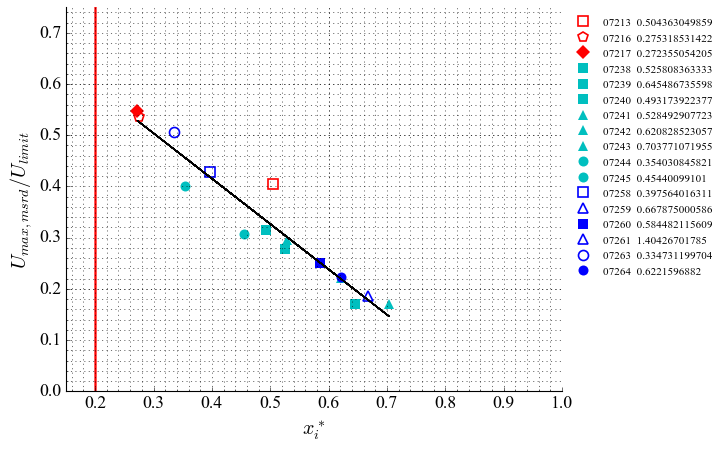

In [40]:
from matplotlib.lines import Line2D
v_max = ((4*0.072*9.81)/1000)**(1/4.)*1000
fig1 = plt.figure(facecolor="white")
for key in xi_norm:
    R = ((3000*meta[key]['Volume'])/(4*math.pi))**(1/3)
    sin_angl = math.sin((meta[key]['Angle']/2)*(math.pi/180))
    x_max_theo = (R/sin_angl)
    
    if x_max[key]>x_max_theo:
        fill = 'none'
        w = 1.5
      
    elif x_max[key]<=x_max_theo:
        fill = 'full'
        w=0
        
    if meta[key]['Angle']== 2.0:
        clr = 'c'
    elif meta[key]['Angle']== 3.5:
        clr = 'b'
    elif meta[key]['Angle']== 5.0:
        clr = 'r'
        
    if meta[key]['Volume']== 0.5:
        style = '^'
    elif meta[key]['Volume']== 1.0:
        style = 's'
    elif meta[key]['Volume']== 2.0:
        style = 'o'
    elif meta[key]['Volume']== 5.0:
        style = 'p'
    elif meta[key]['Volume']== 10.0:
        style = 'D'    

    ax = fig1.add_subplot(1,1,1) 
    dropno = key+' '
    vol = str(meta[key]['Volume'])+'ml '
    angl = str(meta[key]['Angle'])+'deg '
    IL = str( data[key][location][0])+'mm '
    xii = ' '+str(xi_norm[key])
    legend_label = dropno+xii
    
    ax.plot(xi_norm[key],v_norm[key]/v_max,\
                marker=style,\
                c = clr,\
                ms=9,\
                fillStyle=fill,\
                markeredgewidth=w,\
                label = legend_label,\
                linestyle = 'none'
           )
    ax.plot(xi_vector,fit_fn(xi_vector)/v_max,'k')
    ax.plot([0.2,0.2],[0,1],'r')
    legend1 = basic_plot_format(subplot_label = ax, \
                      x_label = '$x_i^*$',  \
                      y_label = '$U_{max,msrd}/U_{limit}$', \
                      major_grid = True,  \
                      minor_grid = True,  \
                      legend = True
                     )
    ax.set_xlim([0.15,1])
    ax.set_ylim([0,0.75])
    

fig1.savefig('Figures/dimensionalplot.png',dpi=300,bbox_extra_artists=(legend1,), bbox_inches='tight')
plt.show()

Red = $5.0^o$ 

Blue = $3.5^o$

light Blue = $2.0^o$



Triangle = $0.5$mL

Square = $1.0$mL

Circle = $2.0$mL

Hexagon = $5.0$mL

Diamond = $10.0$mL

linear trend of max velocity? capillary confinement parameter $x_i^* = x_i \sin\alpha(\frac{4 \pi}{3 V})^{1/3}  $ where $x_i$ is the initial location of the droplet relative to the wedge vertex, $V$ is the droplet volume, and $\alpha$ is the wedge half angle. $U_{limit}$ is found by thermodynamic principles of conservation of energy: access of surface energy associated with unconfined state compare to the initial state is assumed to be completely transferred to kinetic energy (alternative description, capillary pressure gradients associated with surface curvatures). Under limits of large volume small angle experiments, a theoretical velocity is found to be $U_{limit} = (\frac{4 \sigma g}{\rho})^{1/4}$. 

Energy model dependent on volume can be computed. Shown below. Not linear, hm.

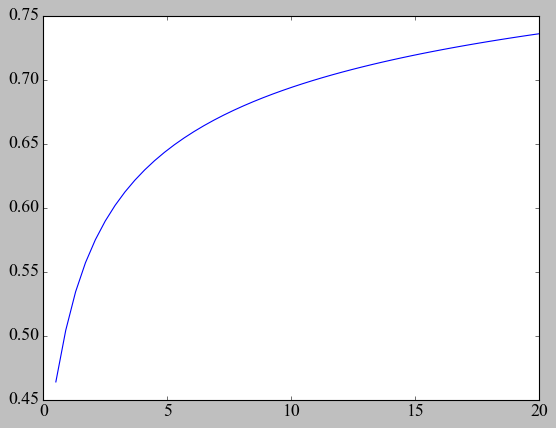

In [41]:
Vtheo = np.linspace(0.5,20)
Hcap = 2*(0.072/(1000*9.81))**(1/2)*1000
term1 = -2*math.cos(150*(math.pi/180))
term2 = 2*((math.pi*Hcap**3)/(Vtheo*1000))**(1/2)
term3 = -6**(2/3)*((math.pi*Hcap**3)/(Vtheo*1000))**(1/3)
Utheo = (0.072*9.81/1000)**(1/4)*(term1+term2+term3)**(1/2)
plt.plot(Vtheo,Utheo*(1000/v_max))
plt.show()

In [42]:
center = {}
for key in sorted(meta):
    center[key] = meta[key]['Center']
RAW_files = os.path.join(dir_path,'RAW_Spotlight','*back.txt')
RAW_back = glob.glob(RAW_files)

x0 = {}
for i in range(n_files):
    key = RAW_back[i].split('\\')[6][:5]
    x0_r = float(RAW_back[i].split('\\')[6].split('_')[3][:5].replace('o','.'))
    f = open(RAW_back[i],"r")
    ff = f.readlines()
    x0[key] = float(ff[9].split()[3])
    f.close()
x0

{'07213': 254.81661,
 '07216': 238.85695,
 '07217': 248.89898,
 '07238': 201.70248,
 '07239': 152.14413,
 '07240': 213.1009,
 '07241': 229.78554,
 '07242': 202.69365,
 '07243': 163.87294,
 '07244': 224.33413,
 '07245': 180.55758,
 '07258': 256.99035,
 '07259': 214.80684,
 '07260': 221.98701,
 '07261': 123.11005,
 '07263': 260.87962,
 '07264': 188.18036}

In [43]:
from sympy import *

thetaf = 180*(math.pi/180)
thetab = 180*(math.pi/180)
alpha = 2.5*(math.pi/180)
gammaf = thetaf - alpha - (math.pi/2)
gammab = thetab + alpha - (math.pi/2)
gamma_approx = theta - (math.pi/2)

beta1f = (2*gammaf - math.sin(2*gammaf))/(2*(math.sin(gammaf)**2))
beta1b = (2*gammab - math.sin(2*gammab))/(2*(math.sin(gammab)**2))
beta2f = ((2./3) - (beta1f/math.tan(gammaf)))
beta2b = ((2./3) - (beta1b/math.tan(gammab)))

V = 1000 # 1mL or 1000mm3
Rv = ((3*V)/(4*math.pi))**(1/3)

xs = np.linspace(5.4/math.tan(2*alpha),Rv/math.sin(alpha))
xave_theo = np.zeros(np.size(xs))
eqs = np.zeros(np.size(xs))
r = Symbol('r')
for i in range(np.size(xs)):
    x = xs[i]
    term0 = math.pi*r*(math.tan(alpha)**2)
    term1 = (math.tan(alpha)/r)*(((x-r)**3)*beta2f + ((x+r)**3)*beta2b)
    term2 = (((x-r)**2)*beta1f + ((x+r)**2)*beta1b)
    term3 = 2*math.pi*(r**2)*x*math.tan(alpha)
    eq = (term0*(term1+term2))+term3 - V
    
    eq_solved = solve(eq,r)
    rr = re(eq_solved[2])
    hb = (((x-rr)*math.tan(alpha))/math.sin(gammab))*(1-math.cos(gammab))
    hf = (((x+rr)*math.tan(alpha))/math.sin(gammaf))*(1-math.cos(gammaf))
    eqs[i]=2*rr+hb+hf
    xave_theo[i] = ((x-rr-hb)+(x+rr+hf))/2
print('done')

done


In [44]:
back1 = data['07213']['back']
front1 = data['07213']['front']
xave1 = data['07213']['average']

diameter1 = front1-back1
d1_filt1 = signal.savgol_filter(diameter1,111,3)
d1_filt2 = signal.savgol_filter(d1_filt1,109,3)
d1_filt3 = signal.savgol_filter(d1_filt2,55,3)
d1_filt4 = signal.savgol_filter(d1_filt3,25,3)

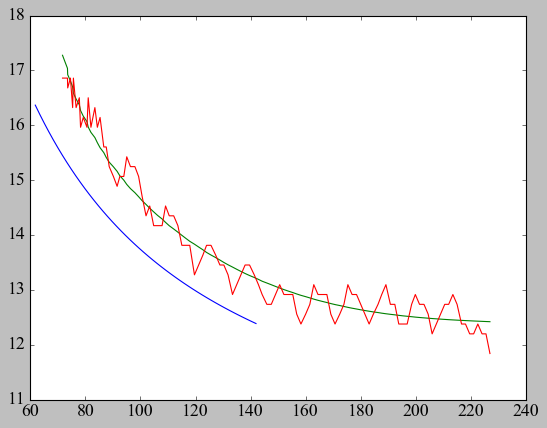

112

In [48]:
plt.plot(xave_theo,eqs,xave1,d1_filt2,xave1,diameter1)
plt.show()
np.size(diameter1)

In [46]:
eqs

array([ 16.36712587,  16.19865909,  16.0374411 ,  15.88302114,
        15.73498572,  15.59295473,  15.45657809,  15.32553272,
        15.19951994,  15.07826312,  14.96150564,  14.84900905,
        14.74055145,  14.63592604,  14.53493977,  14.43741224,
        14.34317462,  14.25206869,  14.16394601,  14.07866713,
        13.99610091,  13.9161239 ,  13.83861972,  13.76347857,
        13.69059673,  13.61987617,  13.55122409,  13.4845526 ,
        13.41977836,  13.35682228,  13.29560924,  13.23606785,
        13.17813017,  13.12173149,  13.06681019,  13.01330745,
        12.96116716,  12.91033573,  12.86076191,  12.81239669,
        12.76519316,  12.71910636,  12.6740932 ,  12.63011236,
        12.58712415,  12.54509045,  12.50397462,  12.46374142,
        12.4243569 ,  12.3857884 ])